# Damage Assesment - DisaVu project

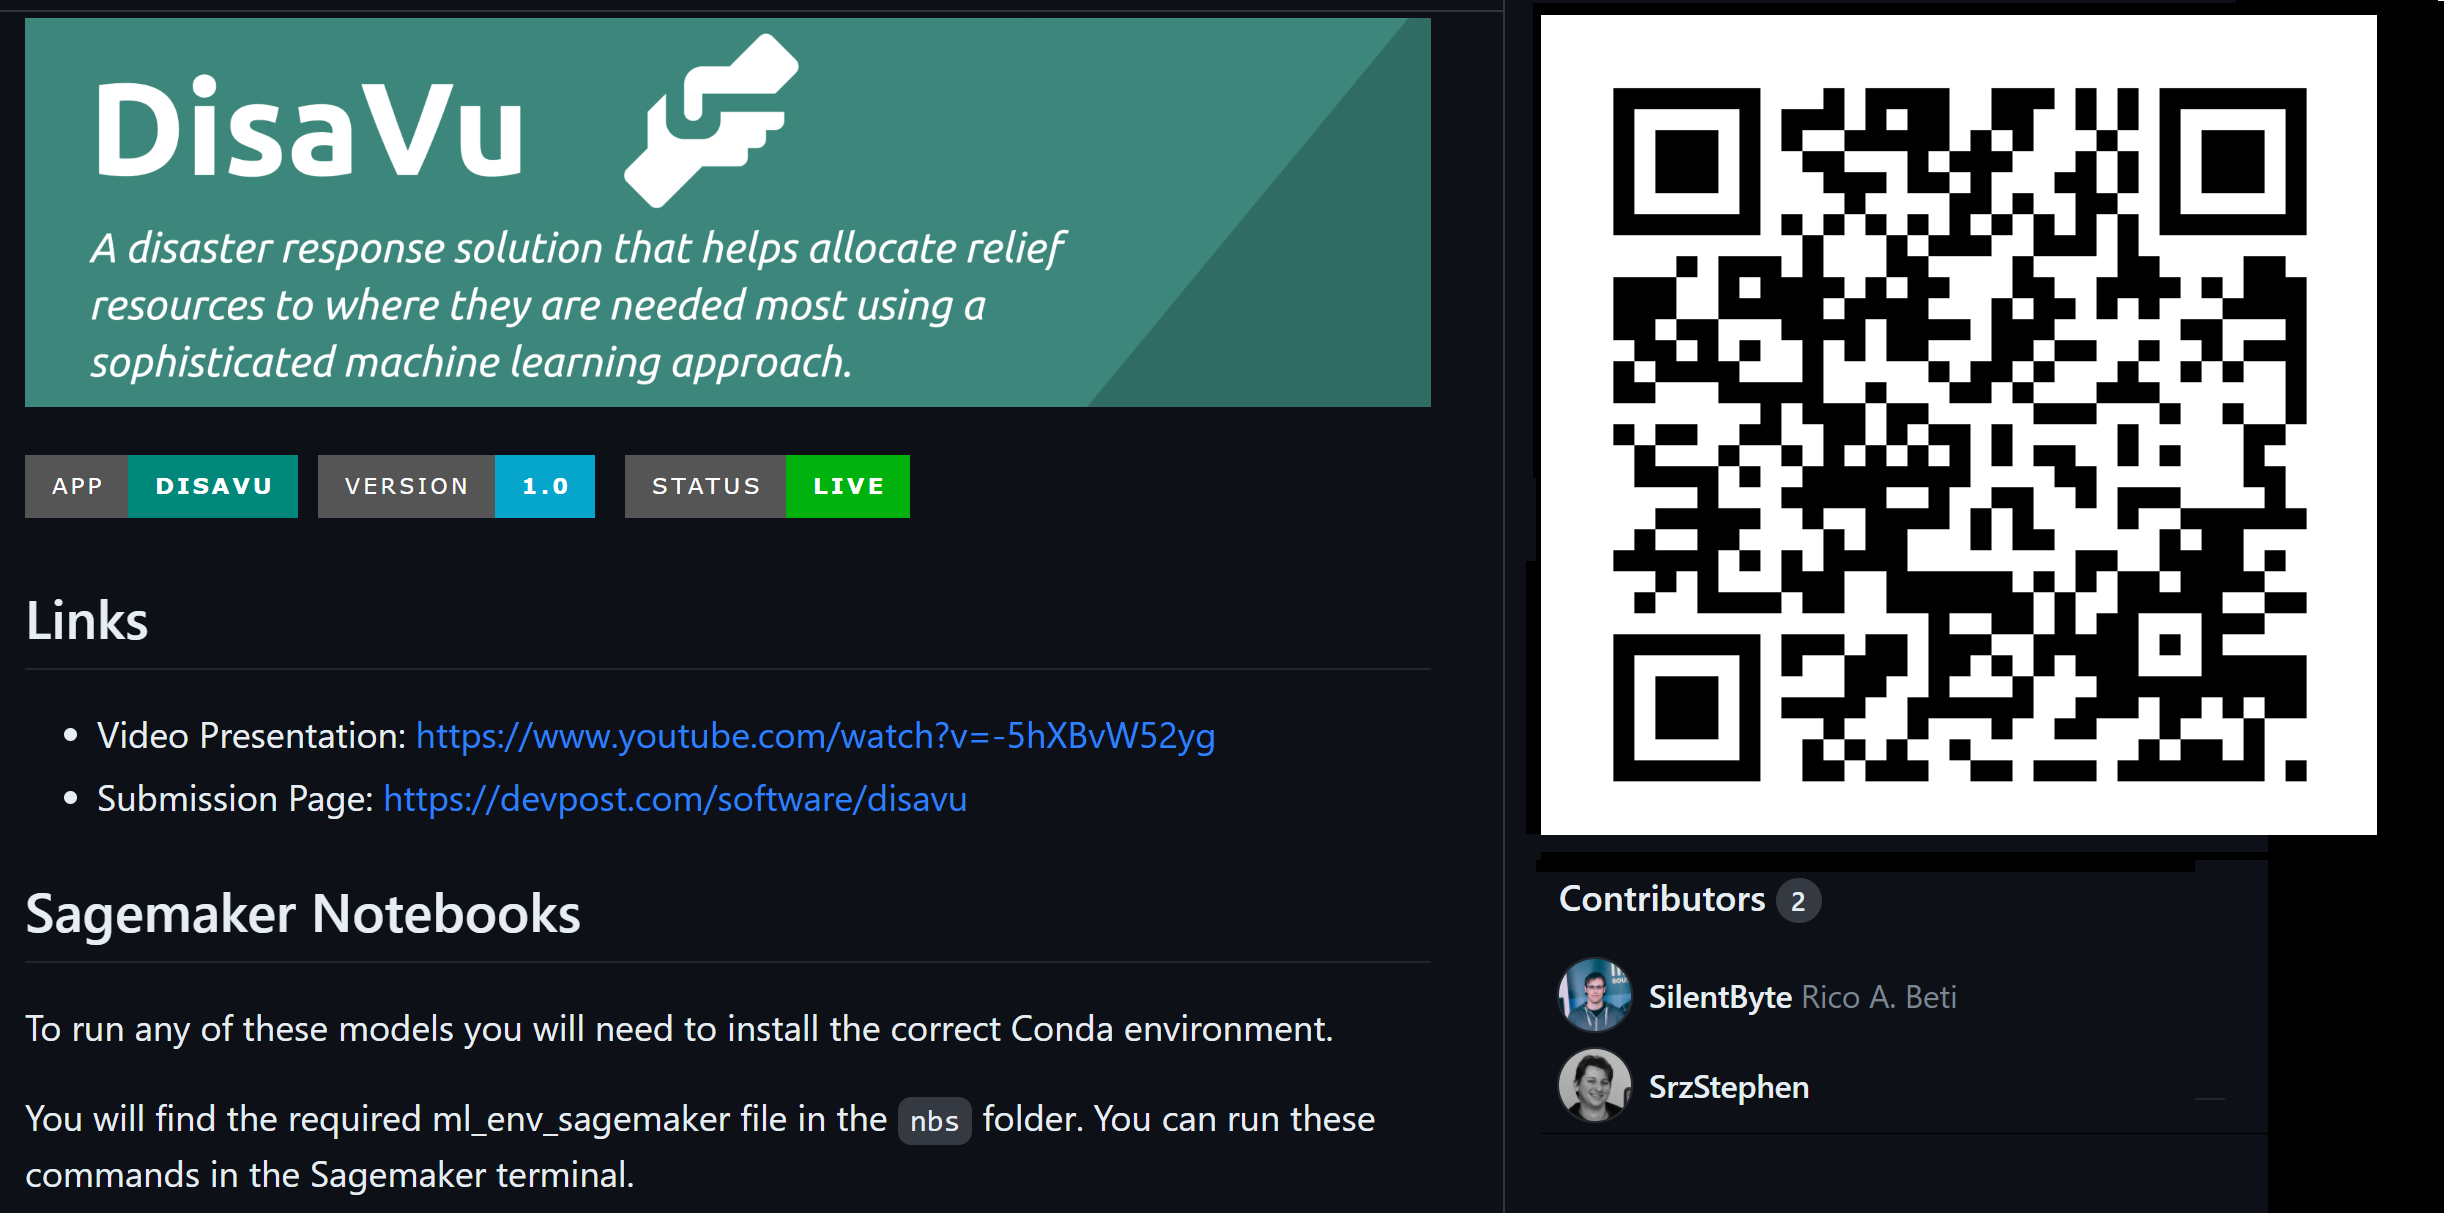

## Install dependencies

In [2]:
import sys
! pip install schemdraw

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision.all import *
from fastai.callback.tensorboard import TensorBoardCallback
from shapely import wkt

In [4]:
from fastai.vision.all import *
from typing import Tuple, List, Union
from typing_extensions import Literal, TypedDict
from pathlib import Path
import json
from re import match
from functools import lru_cache
from sklearn.model_selection import train_test_split
import PIL
from fastai.data.core import DataLoaders
import shutil
from fastai.callback.all import *
from fastprogress import fastprogress
import requests, zipfile
fastprogress.printing = lambda: True
import requests
import tarfile
import boto3
from fastai.interpret import ClassificationInterpretation, Interpretation

### Flow chart showing DisaVu logic

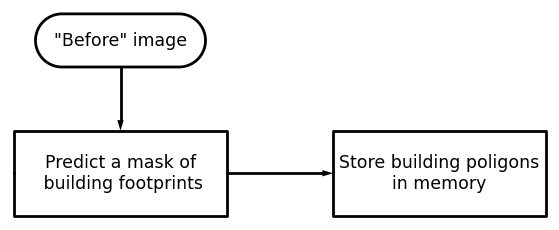

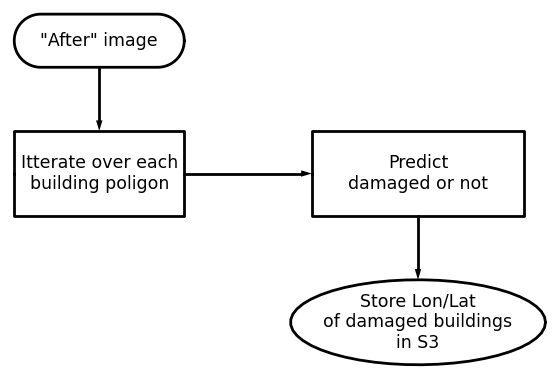

In [5]:
import schemdraw
from schemdraw.flow import *

schemdraw.theme('default')
with schemdraw.Drawing() as d:
    d+= Start(w = 4).label("\"Before\" image")
    d+= Arrow().down(d.unit/2)
    
   
    d+= (box := Box(w = 5).label("Predict a mask of\n building footprints"))
    d+= Arrow().right(d.unit/1.2).at(box.E)
    
  
    d+= (box1 := Box(w = 5).label("Store building poligons\nin memory") )

with schemdraw.Drawing() as d:
    d+= Start(w = 4).label("\"After\" image")
    d+= Arrow().down(d.unit/2)

    d+= (box1 := Box(w = 4).label("Itterate over each\nbuilding poligon") )
    d+= Arrow().right(d.unit).at(box1.E)


    d+= (box := Box(w = 5).label("Predict\ndamaged or not"))
    d+= Arrow().down(d.unit/2).at(box.S)
    

    d+= (end := Ellipse(w=6).label("Store Lon/Lat\nof damaged buildings\nin S3"))
    

## Download damaged buildings data source

In [6]:
base_dir = Path('/tmp')
download_dir = base_dir / "download"
if not download_dir.exists():
    download_dir.mkdir(parents=True)
    
file_url = "https://stephenbucketsagemaker.s3.amazonaws.com/xview2_damage_train_data.tar.gz"
file_name = file_url.split("/")[-1]
file_dir = download_dir / file_name

def download_file(file_url:str,to_file:Path) -> None:
    # Too much indentation for my brain to follow
    print("Downloading file")
    with requests.get(url=file_url,stream=True) as req:
        req.raise_for_status()
        with open(to_file,'wb') as fp:
            for chunk in req.iter_content(chunk_size=2**12):
                fp.write(chunk)

# __file__ doesnt exist in notebooks. I did not know that! so you'll see a lot of Path().resolve()\

if not file_dir.exists():
    download_file(file_url=file_url,to_file = file_dir)
shutil.unpack_archive(filename=file_dir,
                      extract_dir=download_dir,
                      format='gztar')



In [7]:
def get_labels_in_memory(my_dir:Path, trim_by_size=False,trim_size_px=25*25)-> dict:
    return_dict = {}
    n_items = 0
    n_not_trimmed =0
    for item in my_dir.glob('*_post_disaster.json'):
        with open(item.absolute()) as fp:
            for item in json.load(fp)['features']['xy']:
                n_items +=1
                uid = item['properties']['uid']
                output = item['properties']['subtype']
                if trim_by_size:
                    poly = wkt.loads(item['wkt'])
                    if poly.area > trim_size_px:
                        n_not_trimmed+=1
                        return_dict[uid] = output
                else:
                    return_dict[uid] = output
    if trim_by_size:
        print(f"Shown {n_not_trimmed} out of {n_items}")
    return return_dict
# It would be MUCH more efficent space wise to pre filter the data based on this
# But I don't actually know what I want to do, I'm kinda playing this by ear.
label_list = get_labels_in_memory(my_dir=download_dir / "labels",trim_by_size=True,trim_size_px=25*25)

label_types = set([x for x in label_list.values()])
print(label_types)

Shown 83825 out of 162787
{'destroyed', 'minor-damage', 'un-classified', 'no-damage', 'major-damage'}


In [8]:
# Modify so that we only care about major-damage/destroyed, no-damage and minor damage gets treated as undamaged
# Ignore un-classified
unclassified_uids = [k for k,v in label_list.items() if v =='un-classified']

label_list = {k:'undamaged' if v in ['no-damage'] else 'damaged' for k,v in label_list.items() if v not in ['un-classified','minor-damage']}
label_list_damage_type = dict(
    damaged = [k for k,v in label_list.items() if v=='damaged'],
    undamaged = [k for k,v in label_list.items() if v=='undamaged'],

)

In [10]:
labels = ['undamaged','damaged']
# UID
uid_extract = re.compile('[a-fA-F0-9]{8}-[a-fA-F0-9]{4}-[a-fA-F0-9]{4}-[a-fA-F0-9]{4}-[a-fA-F0-9]{12}')
# test
print(uid_extract.search(label_list_damage_type['damaged'][0])[0])

@lru_cache(maxsize=len(label_list_damage_type['damaged']) + len(label_list_damage_type['undamaged']))
def label_func(filename:Union[str,Path])-> str:
    if not isinstance(filename,str):
        return label_list[uid_extract.search(filename.absolute().__str__())[0]]
    else:
        return label_list[uid_extract.search(filename)[0]]
print(label_func(label_list_damage_type['damaged'][0]))
print(label_func(label_list_damage_type['undamaged'][0]))

a8678326-05eb-4054-95ac-64a5d0d5bcfb
damaged
undamaged


In [12]:
base = download_dir / "split_into_label_folder"
for label in labels:
    p = Path(base/ label)
    print(p)
    if p.exists():
        shutil.rmtree(p.absolute().__str__())
    p.mkdir(parents=True)

/tmp/download/split_into_label_folder/undamaged
/tmp/download/split_into_label_folder/damaged


In [13]:
for file in image_filenames:
    f_path = Path(file)
    try:
        shutil.copy(file, base / label_func(f_path) / f_path.name)
    except Exception as e:
        print(file)
        print(e)
        pass

In [14]:
def open_image(fname, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0


In [15]:
@lru_cache()
def label_func(filename:Union[str,Path])-> str:
    if type(filename) != str:
        return label_list[uid_extract.search(filename.absolute().__str__())[0]]
    else:
        return label_list[uid_extract.search(filename)[0]]
from fastai.vision.core import *
from fastai.vision.data import *

db = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter = RandomSplitter(valid_pct=0.2,seed=42),
    get_y = label_func,
    item_tfms=Resize(256),
)

True


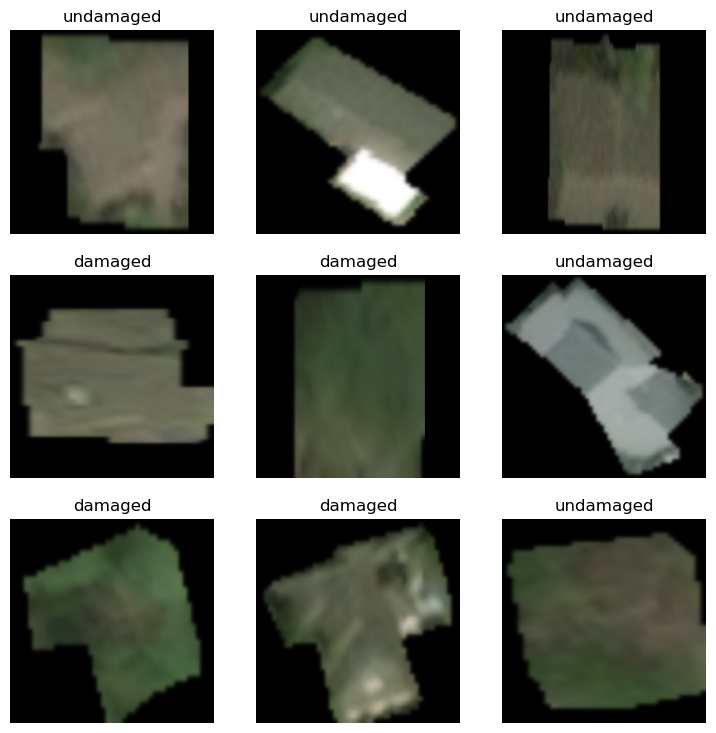

In [16]:
batch_tfms = [Normalize.from_stats(*imagenet_stats)] #

dl = db.dataloaders(base,shuffle=True,bs=64,batch_tfms=batch_tfms)
print(dl.shuffle)
dl.show_batch()

In [17]:
# Really quick workaround to an issue with the version of the fastai libs that I'm using
# Functionally this is VERY minor modification to the original https://github.com/fastai/fastai/blob/master/fastai/interpret.py#L75

# Basically right now on datasets this large you've got an issue where all the memory can be chewed up, which means that the notebook crashes. This does a few very small patches to fix this.

class ModInterpretation():
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, learn, dl, losses, act=None):
        store_attr()

    def __getitem__(self, idxs):
        "Return inputs, preds, targs, decoded outputs, and losses at `idxs`"
        if isinstance(idxs, Tensor): idxs = idxs.tolist()
        if not is_listy(idxs): idxs = [idxs]
        items = getattr(self.dl.items, 'iloc', L(self.dl.items))[idxs]
        tmp_dl = self.learn.dls.test_dl(items, with_labels=True, process=not isinstance(self.dl, TabDataLoader))
        inps,preds,targs,decoded = self.learn.get_preds(dl=tmp_dl, with_input=True, with_loss=False,
                                                        with_decoded=True, act=self.act, reorder=False)
        return inps, preds, targs, decoded, self.losses[idxs]

    @classmethod
    def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
        "Construct interpretation object from a learner"
        if dl is None: dl = learn.dls[ds_idx].new(shuffle=False, drop_last=False)
        _,_,losses = learn.get_preds(dl=dl, with_input=False, with_loss=True, with_decoded=False, act=act)
        return cls(learn, dl, losses, act)


class ModClassificationInterpretation(ModInterpretation):
    "Interpretation methods for classification models."

    def __init__(self, learn, dl, losses, act=None):
        super().__init__(learn, dl, losses, act)
        self.vocab = self.dl.vocab
        if is_listy(self.vocab): self.vocab = self.vocab[-1]

    def confusion_matrix(self):
        "Confusion matrix as an `np.ndarray`."
        x = torch.arange(0, len(self.vocab))
        _,targs,decoded = self.learn.get_preds(dl=self.dl, with_decoded=True, with_input=False, act=self.act)
        d,t = flatten_check(decoded, targs)
        cm = ((d==x[:,None]) & (t==x[:,None,None])).long().sum(2)
        return to_np(cm)

    def plot_confusion_matrix(self, normalize=False, title='Confusion matrix', cmap="Blues", norm_dec=2,
                              plot_txt=True, **kwargs):
        "Plot the confusion matrix, with `title` and using `cmap`."
        # This function is mainly copied from the sklearn docs
        cm = self.confusion_matrix()
        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig = plt.figure(**kwargs)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        tick_marks = np.arange(len(self.vocab))
        plt.xticks(tick_marks, self.vocab, rotation=90)
        plt.yticks(tick_marks, self.vocab, rotation=0)

        if plot_txt:
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
                plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

        ax = fig.gca()
        ax.set_ylim(len(self.vocab)-.5,-.5)

        plt.tight_layout()
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.grid(False)

/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=3.893220537065645e-07)

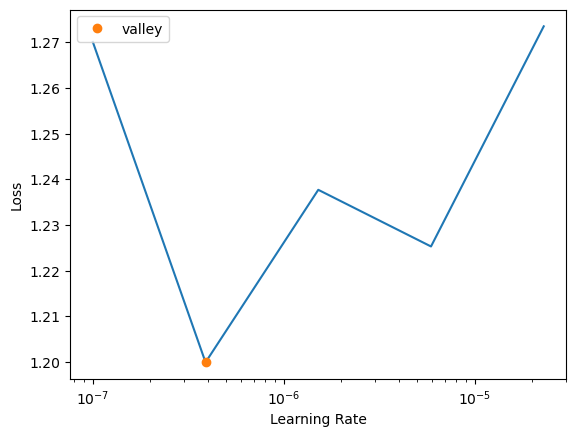

In [18]:
#FloatTensor([0.55,0.45]).cuda()
tensorboard_dir = Path().resolve() / "stage_2_logs"
cb = [TensorBoardCallback(log_dir= str(tensorboard_dir) + "stage_2_frozen"), ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2),EarlyStoppingCallback(monitor='valid_loss')]
learn = cnn_learner(dl, resnet34, metrics=[error_rate,Recall(labels=labels),Precision(labels=labels)],cbs=cb)
learn.lr_find(num_it=10,end_lr=8e-2)

In [ ]:
learn.fit_one_cycle(10,0.0008)

epoch,train_loss,valid_loss,error_rate,recall_score,precision_score,time


In [ ]:
model_name = Path().resolve() / 'predict_damage_frozen'
learn.export(model_name)
learn.save(model_name)

In [ ]:
interp = ModClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:

cb_index = [str(x) for x in learn.cbs].index("TensorBoardCallback")
learn.remove_cb(learn.cbs[cb_index])
learn.add_cb(TensorBoardCallback(log_dir= (tensorboard_dir /  "predict_damage_unfrozen").__str__()))
learn.unfreeze()
learn.fit_one_cycle(8,slice(0.00005,0.0001))


In [ ]:
interp = ModClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
model_name = Path().resolve() / 'predict_damage_unfrozen'
learn.export(model_name)
learn.save(model_name)